# Configurations

In [146]:
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
import pandas as pd

rootFolder = os.getcwd()
os.chdir(rootFolder)
print(rootFolder)
folder = os.listdir('morphologies/')

savedata = 1 # Save Netpyne and BBP soma_voltage

/Users/tarek/Desktop/TMS/Human_L23_NetPyNE-main


In [147]:
folder = [fldr[0:-4] for fldr in folder]
folder

['HL23VIP', 'HL23PYR', 'HL23SST', 'HL23PV']

In [148]:
# !nrnivmodl mod/

In [149]:
from netpyne import sim, specs
import pickle

cfg = specs.SimConfig()     

cfg.duration = 2000 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -80}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['HL23PYR', 'HL23VIP', 'HL23PV', 'HL23SST']

cfg.recordCells = allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'},
                    'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},                  
                    'V_dend_5': {'sec':'dend_5', 'loc':0.5, 'var':'v'},
                    }


## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.025      

cfg.simLabel = 'S1_Net'
cfg.saveFolder = '.'
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData' , 'simConfig', 'netParams', 'netParams']
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			##  
cfg.saveCellConns = True		##  

cfg.analysis['plotTraces'] = {'include': allpops, 'figSize': (12, 4), 'timeRange': [0,cfg.duration], 'saveFig': False, 'overlay': True, 'oneFigPer': 'cell'}  # Plot recorded traces for this list of cells


# Cells distributions and load

In [150]:
#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

# L23 Human net
# #              L2/3   L4     L5
PYRmaxApics = [550   ,1550   ,1900]
uppers =      [-250  ,-1200 ,-1600]
lowers =      [-1200 ,-1580 ,-2300]

L25_human = 250 + 950 + 380 + 720 + 1000
Human_height = 3300.0

netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
cfg.scale = 1.0 # reduce size
cfg.sizeY = 3300.0
cfg.sizeX = 50.0 # r = 25 um ??? find it
cfg.sizeZ = 50.0

netParams.scale = cfg.scale # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume
   
cellModels = ['HH_full']

Ipops = ['HL23VIP', 'HL23PV', 'HL23SST']
Epops = ['HL23PYR']

layer = {'1':[0.0, 250.0], '23': [250.0,1200.0], '4':[1200.0,1580.0], '5': [1580.0,2300.0], '6': [2300.0,3300.0]}  # normalized layer boundaries

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------

for cellName in allpops:
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=True,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper.py',
        cellName='loadCell_' + cellName,
        cellInstance = True,
        cellArgs={'cellName': cellName})

NEURON: NeuronTemplate_HL23PYR : a template cannot be redefined
 in models/NeuronTemplate_HL23PYR.hoc near line 1
 begintemplate NeuronTemplate_HL23PYR
                                    ^
        xopen("models/Neu...")


NeuronTemplate_HL23PYR[0]


NEURON: NeuronTemplate_HL23VIP : a template cannot be redefined
 in models/NeuronTemplate_HL23VIP.hoc near line 1
 begintemplate NeuronTemplate_HL23VIP
                                    ^
        xopen("models/Neu...")


NeuronTemplate_HL23VIP[0]


NEURON: NeuronTemplate_HL23PV : a template cannot be redefined
 in models/NeuronTemplate_HL23PV.hoc near line 1
 begintemplate NeuronTemplate_HL23PV
                                   ^
        xopen("models/Neu...")


NeuronTemplate_HL23PV[0]


NEURON: NeuronTemplate_HL23SST : a template cannot be redefined
 in models/NeuronTemplate_HL23SST.hoc near line 1
 begintemplate NeuronTemplate_HL23SST
                                    ^
        xopen("models/Neu...")


NeuronTemplate_HL23SST[0]


In [151]:
# Rotate to z as vertical

rotate_x = {}
rotate_y = {}
rotate_z = {}
rotate_x['HL23PYR'], rotate_x['HL23SST'], rotate_x['HL23PV'], rotate_x['HL23VIP'] = 1.57, 1.77, 1.26, -1.57
rotate_y['HL23PYR'], rotate_y['HL23SST'], rotate_y['HL23PV'], rotate_y['HL23VIP'] = 2.62, 2.77, 2.57, 3.57
rotate_z['HL23PYR'], rotate_z['HL23SST'], rotate_z['HL23PV'], rotate_z['HL23VIP'] = 0.0, 0.0, 0.0, 0.0


for cellName in netParams.cellParams.keys():

    cellType = netParams.cellParams[cellName]['conds']['cellType']

    x = rotate_x[cellType]
    y = rotate_y[cellType]
    z = rotate_z[cellType]

    for sectName in netParams.cellParams[cellName]['secs'].keys():

        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        theta = -x
        rotation_x = np.array([[1, 0, 0],
                                       [0, np.cos(theta), -np.sin(theta)],
                                       [0, np.sin(theta), np.cos(theta)]])
        
        # print(cellName,sectName,len(sectParams_new))
        # print(sectParams_new)       
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_x)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        phi = -y
        rotation_y = np.array([[np.cos(phi), 0, np.sin(phi)],
                                       [0, 1, 0],
                                       [-np.sin(phi), 0, np.cos(phi)]])
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_y)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        gamma = -z
        rotation_z = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                                       [np.sin(gamma), np.cos(gamma), 0],
                                       [0, 0, 1]])
    
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_z)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams

In [152]:
# Rotate to Y as vertical axis

rotate_x = {}
rotate_y = {}
rotate_z = {}
rotate_x['HL23PYR'], rotate_x['HL23SST'], rotate_x['HL23PV'], rotate_x['HL23VIP'] = -1.5708, -1.5708, -1.5708, -1.5708
rotate_y['HL23PYR'], rotate_y['HL23SST'], rotate_y['HL23PV'], rotate_y['HL23VIP'] = 0.0, 0.0, 0.0, 0.0
rotate_z['HL23PYR'], rotate_z['HL23SST'], rotate_z['HL23PV'], rotate_z['HL23VIP'] = 0.0, 0.0, 0.0, 0.0


for cellName in netParams.cellParams.keys():

    cellType = netParams.cellParams[cellName]['conds']['cellType']

    x = rotate_x[cellType]
    y = rotate_y[cellType]
    z = rotate_z[cellType]

    for sectName in netParams.cellParams[cellName]['secs'].keys():

        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        theta = -x
        rotation_x = np.array([[1, 0, 0],
                                       [0, np.cos(theta), -np.sin(theta)],
                                       [0, np.sin(theta), np.cos(theta)]])
        
        # print(cellName,sectName,len(sectParams_new))
        # print(sectParams_new)       
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_x)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        phi = -y
        rotation_y = np.array([[np.cos(phi), 0, np.sin(phi)],
                                       [0, 1, 0],
                                       [-np.sin(phi), 0, np.cos(phi)]])
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_y)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        gamma = -z
        rotation_z = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                                       [np.sin(gamma), np.cos(gamma), 0],
                                       [0, 0, 1]])
    
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_z)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams

In [153]:
#------------------------------------------------------------------------------
# Cell parameters 
#------------------------------------------------------------------------------

for cellName in netParams.cellParams.keys():
        
        axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['soma_0']['geom']['pt3d'][-1]
        axon_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['diam']
        axon_pt3d_L =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['L']

        netParams.cellParams[cellName]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

        axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['pt3d'][-1]
        axon1_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['diam']
        axon1_pt3d_L =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['L']

        netParams.cellParams[cellName]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)] 
        
        if 'myelin_0' in netParams.cellParams[cellName]['secs'].keys():

                if 'myelin_0' not in netParams.cellParams[cellName]['secLists']['all']:
                        netParams.cellParams[cellName]['secLists']['all'].append('myelin_0')

                if 'myelin_0' not in netParams.cellParams[cellName]['secLists']['axonal']:                        
                        netParams.cellParams[cellName]['secLists']['axonal'].append('myelin_0')

                myelin0_pt3d_x, myelin0_pt3d_y, myelin0_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['pt3d'][-1]
                myelin0_pt3d_diam =  netParams.cellParams[cellName]['secs']['myelin_0']['geom']['diam']
                myelin0_pt3d_L =  netParams.cellParams[cellName]['secs']['myelin_0']['geom']['L']

                netParams.cellParams[cellName]['secs']['myelin_0']['geom']['pt3d'] = [(myelin0_pt3d_x, myelin0_pt3d_y, myelin0_pt3d_z, myelin0_pt3d_diam),
                                                                                (myelin0_pt3d_x, myelin0_pt3d_y+myelin0_pt3d_L/2.0, myelin0_pt3d_z, myelin0_pt3d_diam),
                                                                                (myelin0_pt3d_x, myelin0_pt3d_y+myelin0_pt3d_L, myelin0_pt3d_z, myelin0_pt3d_diam)] 
# print and rename
for cellName in netParams.cellParams.keys():

    netParams.renameCellParamsSec(label=cellName, oldSec='myelin_0', newSec='axon_2')      
           
    for secname2 in netParams.cellParams[cellName]['secLists'].keys():
     if 'myelin_0' in netParams.cellParams[cellName]['secLists'][secname2]:
       print('old ->',cellName,secname2,netParams.cellParams[cellName]['secLists'][secname2][-1])
       netParams.cellParams[cellName]['secLists'][secname2][-1] = 'axon_2'    
       print('new ->',cellName,secname2,netParams.cellParams[cellName]['secLists'][secname2][-1])

old -> HL23PYR_rule all myelin_0
new -> HL23PYR_rule all axon_2
old -> HL23PYR_rule axonal myelin_0
new -> HL23PYR_rule axonal axon_2
old -> HL23SST_rule all myelin_0
new -> HL23SST_rule all axon_2
old -> HL23SST_rule axonal myelin_0
new -> HL23SST_rule axonal axon_2


In [154]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
# cell_num = [800, 50, 70, 80]
cell_num = [8, 2, 2, 2]
#cell_num = [19, 2, 2, 2]
#cell_num = [2, 2, 2, 2]

for ii,cellName in enumerate(['HL23PYR', 'HL23SST', 'HL23PV', 'HL23VIP']):
    netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': cell_num[ii], 'yRange': layer['23']} 


netParams.rotateCellsRandomly = True

# Create Network

In [155]:
#Import Excel file
circuit_params = pd.read_excel('Circuit_param.xls', sheet_name = None, index_col = 0)

#Get cell names and import biophys
cell_names = [i for i in circuit_params['conn_probs'].axes[0]]

circuit_params["syn_params"] = {'none':{'tau_r_AMPA': 0,'tau_d_AMPA': 0,'tau_r_NMDA': 0,
                                'tau_d_NMDA': 0, 'e': 0,'Dep': 0,'Fac': 0,'Use': 0,'u0':0,'gmax': 0}}
circuit_params["multi_syns"] = {'none':{'loc':0,'scale':0}}
# organizing dictionary for LFPY input
for pre in cell_names:
    for post in cell_names:
        if "PYR" in pre:
            circuit_params["syn_params"][pre+post] = {'tau_r_AMPA': 0.3, 'tau_d_AMPA': 3, 'tau_r_NMDA': 2,
                                                      'tau_d_NMDA': 65, 'e': 0, 'u0':0,
                                                      'Dep': circuit_params["Depression"].at[pre, post],
                                                      'Fac': circuit_params["Facilitation"].at[pre, post],
                                                      'Use': circuit_params["Use"].at[pre, post],
                                                      'gmax': circuit_params["syn_cond"].at[pre, post]}
        else:
            circuit_params["syn_params"][pre+post] = {'tau_r': 1, 'tau_d': 10, 'e': -80, 'u0':0,
                                                      'Dep': circuit_params["Depression"].at[pre, post],
                                                      'Fac': circuit_params["Facilitation"].at[pre, post],
                                                      'Use': circuit_params["Use"].at[pre, post],
                                                      'gmax': circuit_params["syn_cond"].at[pre, post]}
        circuit_params["multi_syns"][pre+post] = {'loc':int(circuit_params["n_cont"].at[pre, post]),'scale':0}

circuit_params.keys()
circuit_params['conn_probs']


,HL23PYR,HL23SST,HL23PV,HL23VIP
HL23PYR,0.150,0.19,0.09,0.09
HL23SST,0.190,0.04,0.20,0.06
HL23PV,0.094,0.05,0.37,0.03
HL23VIP,0.000,0.35,0.10,0.05


In [156]:
## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

# Cell connectivity rules
netParams.connParams['E->all'] = {
  'preConds': {'cellType': 'E'}, 
  'postConds': {'y': [50,500]},  #  E -> all (100-1000 um)
  'probability': 0.1,                  # probability of connection
  'weight': '0.04*post_ynorm',         # synaptic weight 
  'delay': 'dist_3D/propVelocity',      # transmission delay (ms) 
  'synMech': 'exc'}                     # synaptic mechanism 

netParams.connParams['I->E'] = {
  'preConds': {'cellType': 'I'}, 
  'postConds': {'pop': ['E2','E4','E5']},       #  I -> E
  'probability': '0.3*exp(-dist_3D/probLengthConst)',   # probability of connection
  'weight': 0.01,                                      # synaptic weight 
  'delay': 'dist_3D/propVelocity',                      # transmission delay (ms) 
  'sec': ['soma','Bdend'], 
  'synMech': 'inh'}                                     # synaptic mechanism 

In [157]:
# for pre in cell_names:
#     for post in cell_names:
#         if "PYR" in pre:
#             netParams.synMechParams[pre+post] = {'mod': 'ProbAMPANMDA',
#                                                   'tau_r_AMPA': 0.3, 'tau_d_AMPA': 3, 'tau_r_NMDA': 2,
#                                                       'tau_d_NMDA': 65, 'e': 0, 'u0':0,
#                                                       'Dep': circuit_params["Depression"].at[pre, post],
#                                                       'Fac': circuit_params["Facilitation"].at[pre, post],
#                                                       'Use': circuit_params["Use"].at[pre, post],
#                                                       'gmax': circuit_params["syn_cond"].at[pre, post]}
#         else:
#             netParams.synMechParams[pre+post] = {'mod': 'ProbUDFsyn',
#                                                  'tau_r': 1, 'tau_d': 10, 'e': -80, 'u0':0,
#                                                       'Dep': circuit_params["Depression"].at[pre, post],
#                                                       'Fac': circuit_params["Facilitation"].at[pre, post],
#                                                       'Use': circuit_params["Use"].at[pre, post],
#                                                       'gmax': circuit_params["syn_cond"].at[pre, post]}
#         circuit_params["multi_syns"][pre+post] = {'loc':int(circuit_params["n_cont"].at[pre, post]),'scale':0}


In [179]:
# for pre in cell_names:
#     for post in cell_names:

#         # print(pre+post,circuit_params['conn_probs'][pre][post],circuit_params['syn_cond'][pre][post])
        
#         if circuit_params['conn_probs'][pre][post] > 0.0:
#             netParams.connParams[pre+post] = {
#                     'preConds': {'pop': pre}, 'postConds': {'pop': post},
#                     'weight': circuit_params['syn_cond'][pre][post],                    # weight of each connection
#                     'synMech': pre+post,
#                     'delay': 0.5,     # 
#                     'probability': circuit_params['conn_probs'][pre][post]}    #


In [180]:
# Organize dictionary for synaptic parameters and connectivity
for pre in cell_names:
    for post in cell_names:
        if "PYR" in pre:  # Excitatory synapses
            circuit_params["syn_params"][pre+post] = {
                'tau1': 0.3, 'tau2': 3,
                'e': 0
            }
        else:  # Inhibitory synapses
            circuit_params["syn_params"][pre+post] = {
                'tau1': 1, 'tau2': 10, 'e': -80
            }
        circuit_params["multi_syns"][pre+post] = {'loc': int(circuit_params["n_cont"].at[pre, post]), 'scale': 0}

# Define synaptic mechanisms and connectivity 
for pre in cell_names:
    for post in cell_names:
        synMechParams = circuit_params["syn_params"][pre+post]
        netParams.synMechParams[pre+post] = {'mod': 'Exp2Syn', **synMechParams}

        if circuit_params['conn_probs'].at[pre, post] > 0.0:
            netParams.connParams[pre+post] = {
                'preConds': {'pop': pre},
                'postConds': {'pop': post},
                'weight': circuit_params["syn_cond"].at[pre, post],
                'synMech': pre+post,
                'delay': 0.5,
                'probability': circuit_params['conn_probs'].at[pre, post]
            }

# # Connectivity Parameters
# connectivity_params = {}

# for pre in cell_names:
#     for post in cell_names:
#         conn_key = f'{pre}->{post}'
#         syn_key = f'{pre}{post}'
#         conn_prob = circuit_params["conn_probs"].at[pre, post]
#         syn_params = circuit_params["syn_params"].get(syn_key, {})

#         if conn_prob > 0:
#             connectivity_params[conn_key] = {
#                 'preConds': {'pop': pre},
#                 'postConds': {'pop': post},
#                 'probability': conn_prob,
#                 'weight': syn_params.get('gmax', 0),  # Ensure default value if gmax is missing
#                 'synMech': 'AMPA' if "PYR" in pre else 'GABA',  # Define mechanism based on pre population
#                 'delay': 0.5
#             }

# connectivity_params = {
#     'HL23PYR->HL23PYR': {
#         'preConds': {'pop': 'HL23PYR'},
#         'postConds': {'pop': 'HL23PYR'},
#         'probability': circuit_params["conn_probs"].at['HL23PYR', 'HL23PYR'],
#         'weight': circuit_params["syn_params"]['HL23PYRHL23PYR']['gmax'],
#         'synMech': 'AMPA',
#         'delay': 0.5
#     },
#     'HL23PYR->HL23SST': {
#         'preConds': {'pop': 'HL23PYR'},
#         'postConds': {'pop': 'HL23SST'},
#         'probability': circuit_params["conn_probs"].at['HL23PYR', 'HL23SST'],
#         'weight': circuit_params["syn_params"]['HL23PYRHL23SST']['gmax'],
#         'synMech': 'AMPA',
#         'delay': 0.5
#     },
#     'HL23PYR->HL23PV': {
#         'preConds': {'pop': 'HL23PYR'},
#         'postConds': {'pop': 'HL23PV'},
#         'probability': circuit_params["conn_probs"].at['HL23PYR', 'HL23PV'],
#         'weight': circuit_params["syn_params"]['HL23PYRHL23PV']['gmax'],
#         'synMech': 'AMPA',
#         'delay': 0.5
#     },
#     'HL23PYR->HL23VIP': {
#         'preConds': {'pop': 'HL23PYR'},
#         'postConds': {'pop': 'HL23VIP'},
#         'probability': circuit_params["conn_probs"].at['HL23PYR', 'HL23VIP'],
#         'weight': circuit_params["syn_params"]['HL23PYRHL23VIP']['gmax'],
#         'synMech': 'AMPA',
#         'delay': 0.5
#     },
#     'HL23PV->HL23PYR': {
#         'preConds': {'pop': 'HL23PV'},
#         'postConds': {'pop': 'HL23PYR'},
#         'probability': circuit_params["conn_probs"].at['HL23PV', 'HL23PYR'],
#         'weight': circuit_params["syn_params"]['HL23PVHL23PYR']['gmax'],
#         'synMech': 'GABA',
#         'delay': 0.5
#     },
#     'HL23PV->HL23SST': {
#         'preConds': {'pop': 'HL23PV'},
#         'postConds': {'pop': 'HL23SST'},
#         'probability': circuit_params["conn_probs"].at['HL23PV', 'HL23SST'],
#         'weight': circuit_params["syn_params"]['HL23PVHL23SST']['gmax'],
#         'synMech': 'GABA',
#         'delay': 0.5
#     },
#     'HL23SST->HL23PYR': {
#         'preConds': {'pop': 'HL23SST'},
#         'postConds': {'pop': 'HL23PYR'},
#         'probability': circuit_params["conn_probs"].at['HL23SST', 'HL23PYR'],
#         'weight': circuit_params["syn_params"]['HL23SSTHL23PYR']['gmax'],
#         'synMech': 'GABA',
#         'delay': 0.5
#     },
#     'HL23SST->HL23PV': {
#         'preConds': {'pop': 'HL23SST'},
#         'postConds': {'pop': 'HL23PV'},
#         'probability': circuit_params["conn_probs"].at['HL23SST', 'HL23PV'],
#         'weight': circuit_params["syn_params"]['HL23SSTHL23PV']['gmax'],
#         'synMech': 'GABA',
#         'delay': 0.5
#     },
#     'HL23SST->HL23VIP': {
#         'preConds': {'pop': 'HL23SST'},
#         'postConds': {'pop': 'HL23VIP'},
#         'probability': circuit_params["conn_probs"].at['HL23SST', 'HL23VIP'],
#         'weight': circuit_params["syn_params"]['HL23SSTHL23VIP']['gmax'],
#         'synMech': 'GABA',
#         'delay': 0.5
#     },
#     'HL23VIP->HL23PYR': {
#         'preConds': {'pop': 'HL23VIP'},
#         'postConds': {'pop': 'HL23PYR'},
#         'probability': circuit_params["conn_probs"].at['HL23VIP', 'HL23PYR'],
#         'weight': circuit_params["syn_params"]['HL23VIPHL23PYR']['gmax'],
#         'synMech': 'GABA',
#         'delay': 0.5
#     },
#     'HL23VIP->HL23SST': {
#         'preConds': {'pop': 'HL23VIP'},
#         'postConds': {'pop': 'HL23SST'},
#         'probability': circuit_params["conn_probs"].at['HL23VIP', 'HL23SST'],
#         'weight': circuit_params["syn_params"]['HL23VIPHL23SST']['gmax'],
#         'synMech': 'GABA',
#         'delay': 0.5
#     },
#     'HL23VIP->HL23PV': {
#         'preConds': {'pop': 'HL23VIP'},
#         'postConds': {'pop': 'HL23PV'},
#         'probability': circuit_params["conn_probs"].at['HL23VIP', 'HL23PV'],
#         'weight': circuit_params["syn_params"]['HL23VIPHL23PV']['gmax'],
#         'synMech': 'GABA',
#         'delay': 0.5
#     }
# }

netParams.connParams.update(connectivity_params)

# Define synaptic mechanisms directly for clarity
netParams.synMechParams['AMPA'] = {'mod': 'Exp2Syn', 'tau1': 0.3, 'tau2': 3, 'e': 0}
netParams.synMechParams['GABA'] = {'mod': 'Exp2Syn', 'tau1': 1, 'tau2': 10, 'e': -80}



In [181]:
#Synaptic mechanism parameters
netParams.synMechParams['AMPA'] = {'mod': 'Exp2Syn', 'tau1': 0.05, 'tau2': 5.3, 'e': 0}  # AMPA
netParams.synMechParams['NMDA'] = {'mod': 'Exp2Syn', 'tau1': 0.15, 'tau2': 15, 'e': 0}  # NMDA
netParams.synMechParams['GABAA'] = {'mod': 'Exp2Syn', 'tau1': 0.07, 'tau2': 9.1, 'e': -80}  # GABAA
netParams.synMechParams['GABAB'] = {'mod': 'Exp2Syn', 'tau1': 0.07, 'tau2': 9.1, 'e': -80}  # GABAB


#Stimulation parameters
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 1}
netParams.stimSourceParams['bkg2'] = {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 1}
netParams.stimTargetParams['bkg->PYR'] = {'source': 'bkg', 'conds': {'pop': 'HL23PYR'}, 'weight': 0.001, 'delay': 'uniform(1,5)'}
netParams.stimTargetParams['bkg->IN'] = {'source': 'bkg2', 'conds': {'pop': ['HL23SST', 'HL23PV', 'HL23VIP']}, 'weight': 0.001, 'delay': 'uniform(1,5)'}


## Run 

In [182]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)


Start time:  2024-07-25 01:08:24.245931

Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 14 
  Done; cell creation time = 1.49 s.
Making connections...
  Number of connections on node 0: 26 
  Number of synaptic contacts on node 0: 49 
  Done; cell connection time = 0.01 s.
Adding stims...
  Number of stims on node 0: 14 
  Done; cell stims creation time = 0.00 s.
Recording 56 traces of 4 types on node 0


{spkt: Vector[109769], spkid: Vector[109770], stims: {cell_0: {bkg: Vector[109771]}, cell_1: {bkg: Vector[109772]}, cell_2: {bkg: Vector[109773]}, cell_3: {bkg: Vector[109774]}, cell_4: {bkg: Vector[109775]}, cell_5: {bkg: Vector[109776]}, cell_6: {bkg: Vector[109777]}, cell_7: {bkg: Vector[109778]}, cell_8: {bkg2: Vector[109779]}, cell_9: {bkg2: Vector[109780]}, cell_10: {bkg2: Vector[109781]}, cell_11: {bkg2: Vector[109782]}, cell_12: {bkg2: Vector[109783]}, cell_13: {bkg2: Vector[109784]}}, V_soma: {cell_0: Vector[109827], cell_1: Vector[109830], cell_2: Vector[109833], cell_3: Vector[109836], cell_4: Vector[109839], cell_5: Vector[109842], cell_6: Vector[109845], cell_7: Vector[109848], cell_8: Vector[109851], cell_9: Vector[109854], cell_10: Vector[109857], cell_11: Vector[109860], cell_12: Vector[109863], cell_13: Vector[109866]}, V_axon_0: {cell_0: Vector[109828], cell_1: Vector[109831], cell_2: Vector[109834], cell_3: Vector[109837], cell_4: Vector[109840], cell_5: Vector[10984

0.0s

Running simulation using NEURON for 2000.0 ms...
0.5s
1.0s
1.5s
2.0s
  Done; run time = 39.43 s; real-time ratio: 0.05.

Gathering data...
  Done; gather time = 1.57 s.

Analyzing...
  Cells: 14
  Connections: 40 (2.86 per cell)
  Synaptic contacts: 63 (4.50 per cell)
  Spikes: 62 (2.21 Hz)
  Simulated time: 2.0 s; 1 workers
  Run time: 39.43 s
   HL23PYR : 3.875 Hz
   HL23SST : 0.000 Hz
   HL23PV : 0.000 Hz
   HL23VIP : 0.000 Hz
Plotting recorded cell traces ... cell


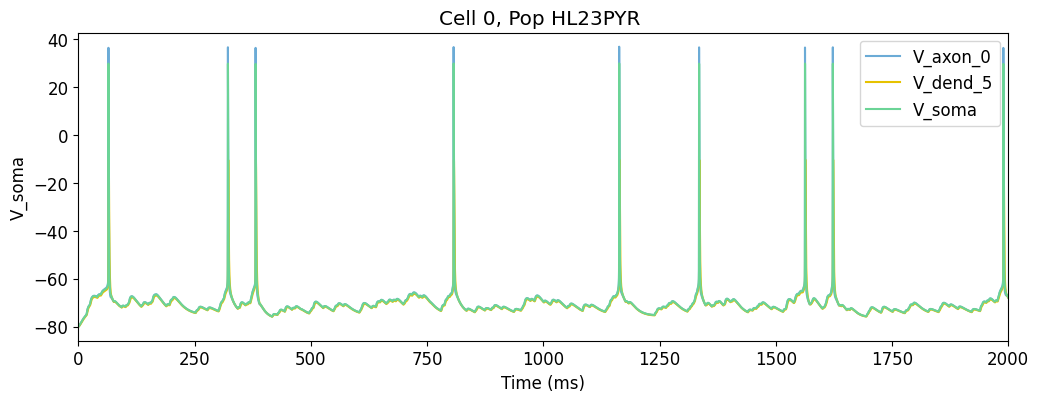

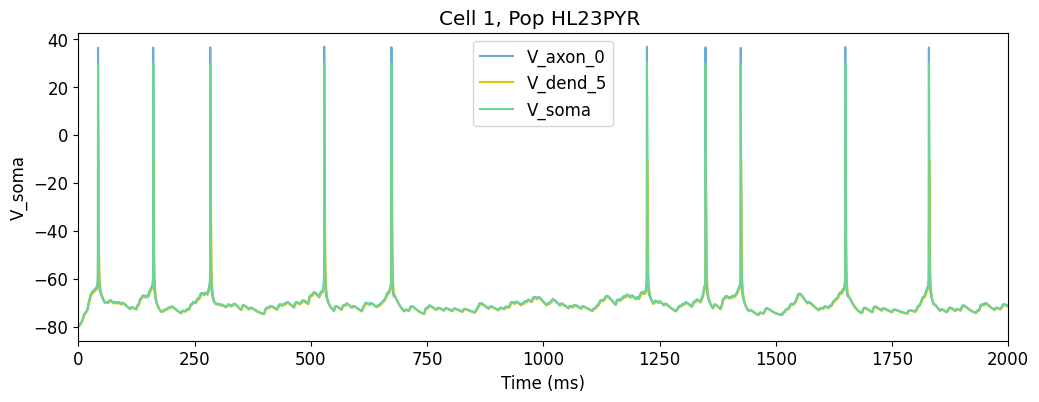

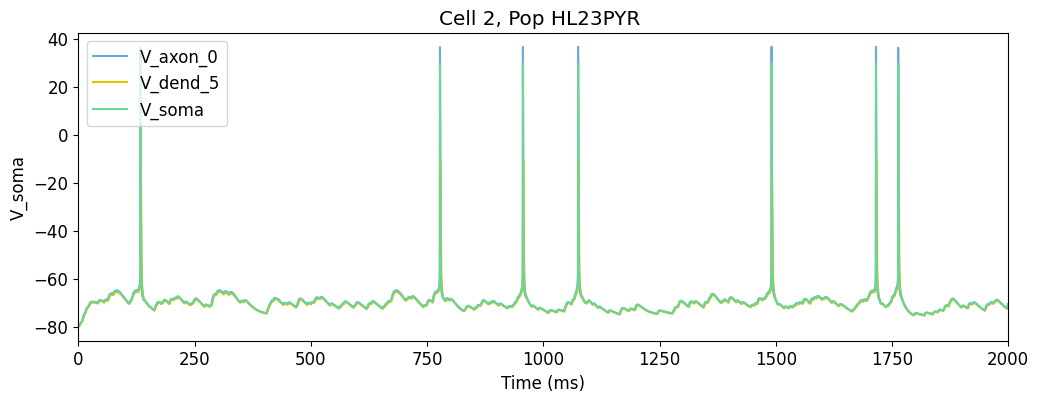

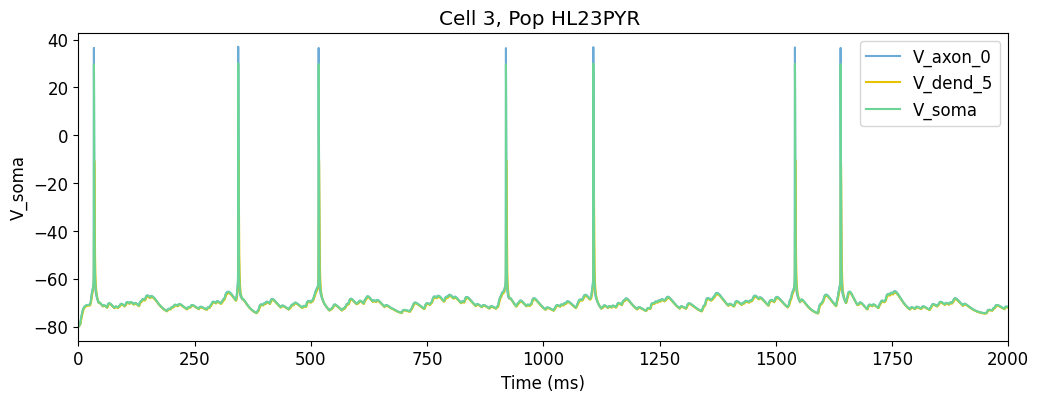

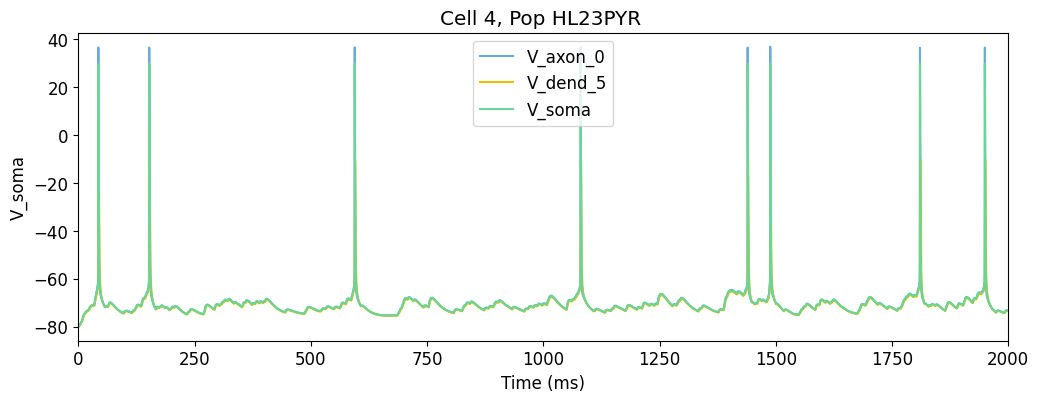

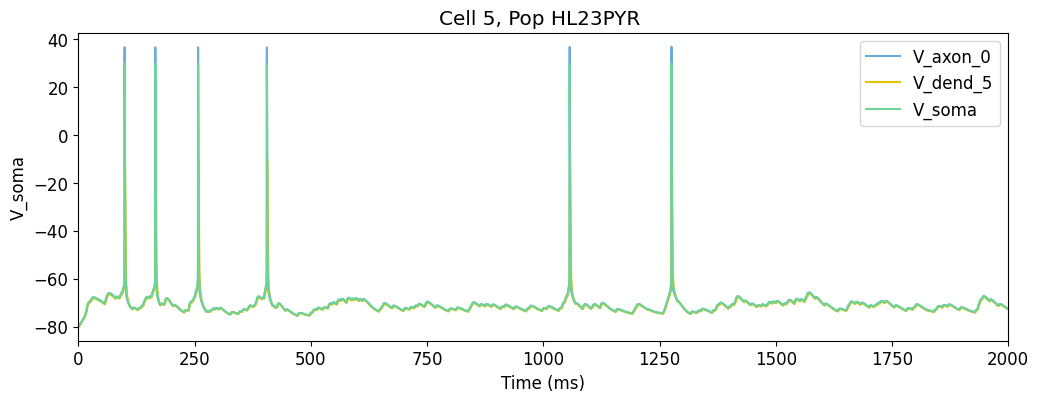

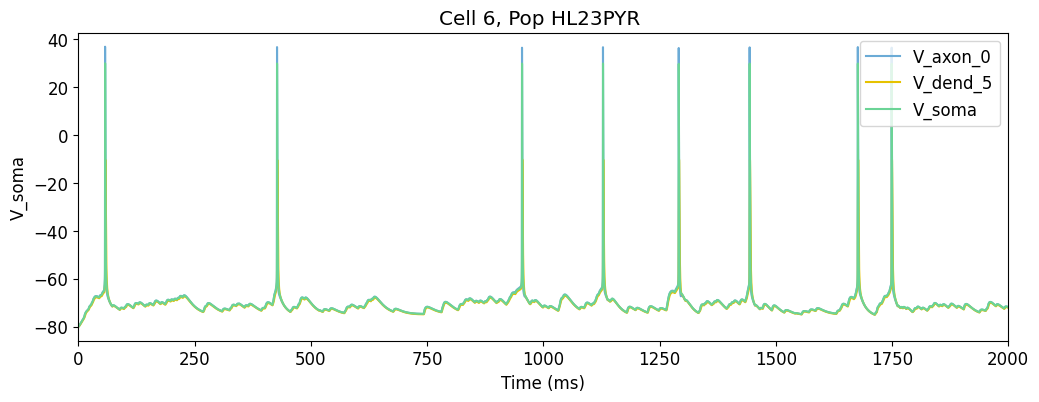

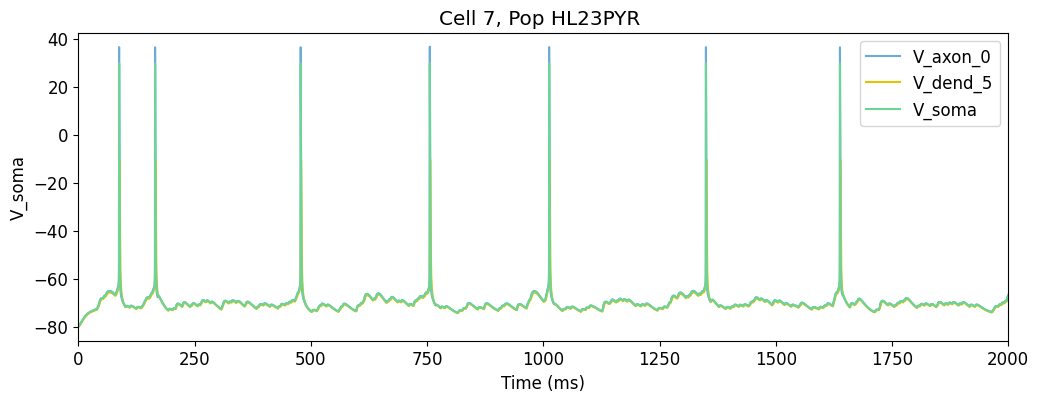

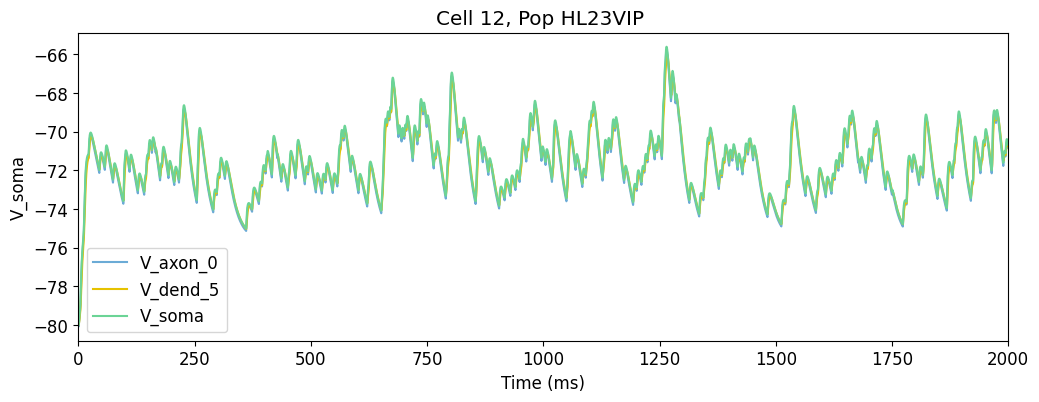

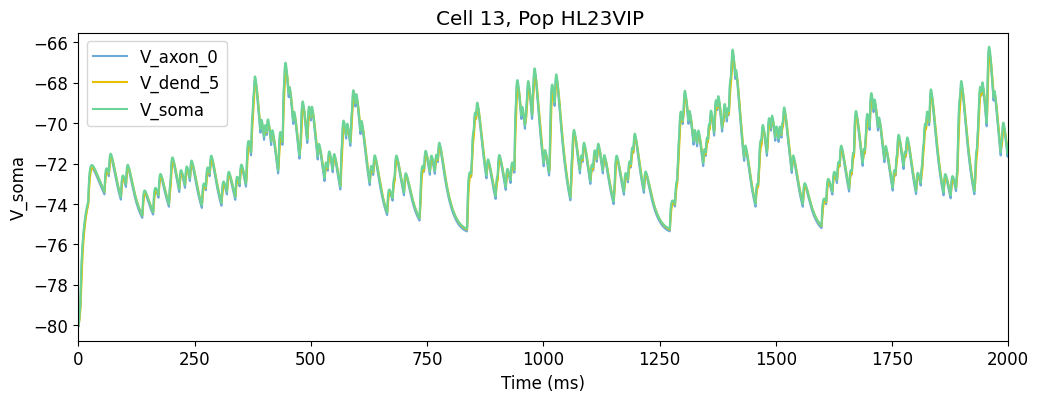

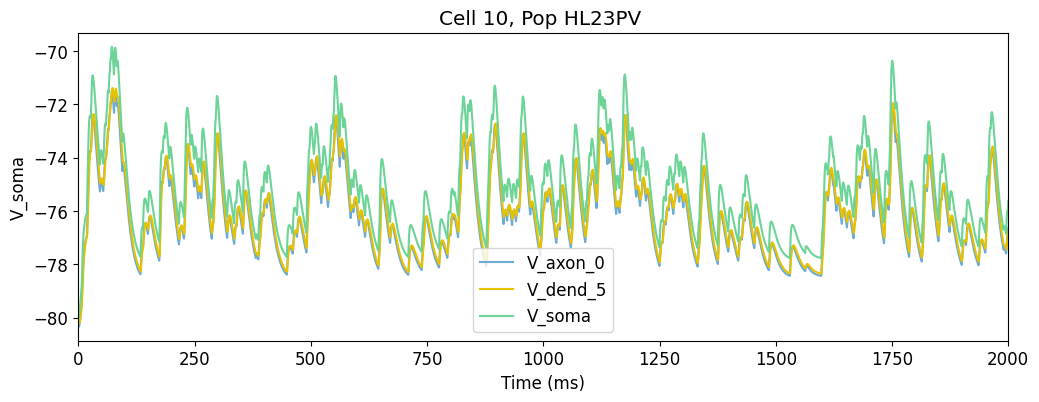

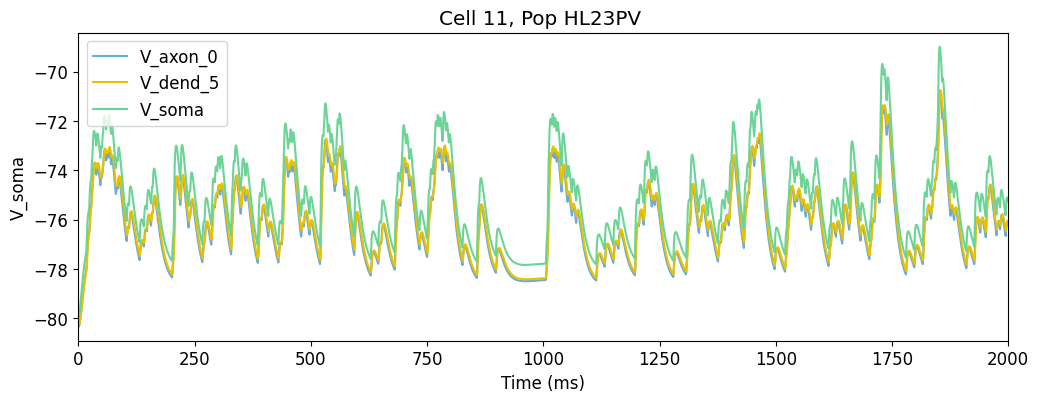

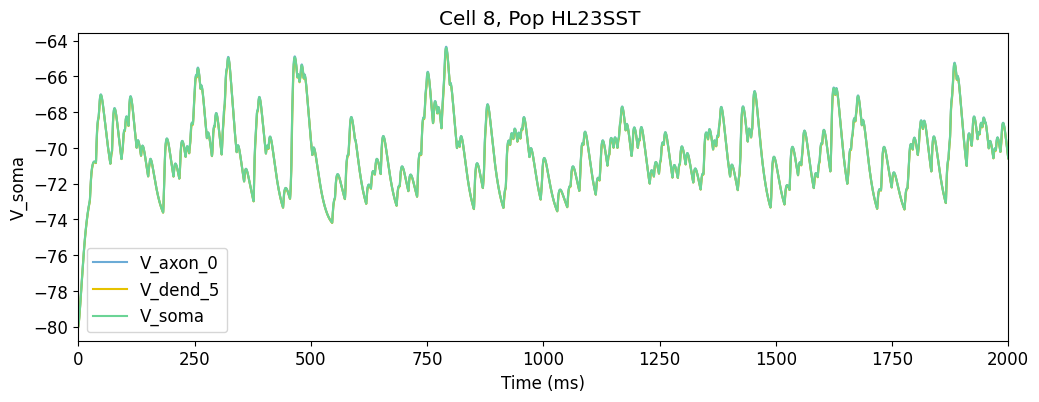

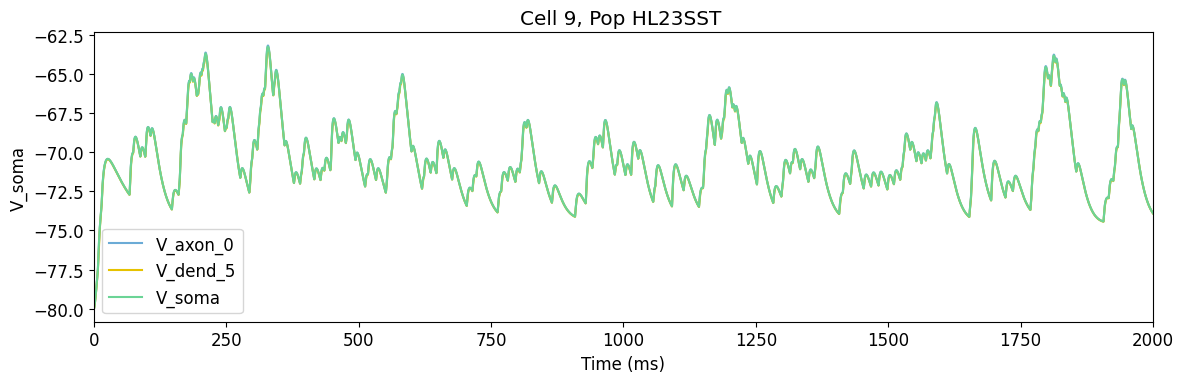

  Done; plotting time = 9.21 s

Total time = 52.95 s
Plotting 3D cell shape ...


(<Figure size 640x480 with 1 Axes>, {})

In [183]:
%matplotlib inline
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc
sim.analysis.plotShape()  

Preparing spike data...
Plotting raster...


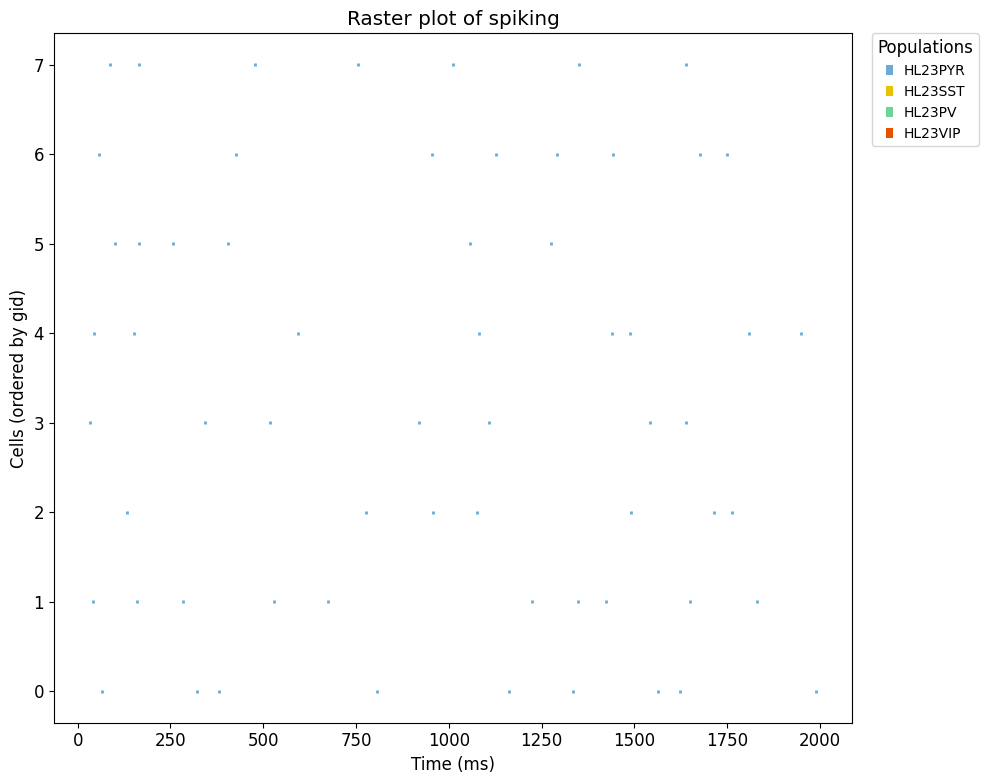

In [184]:
sim.analysis.plotRaster()

In [185]:
for cn,cell_name in enumerate(['HL23PYR', 'HL23VIP', 'HL23PV', 'HL23SST']):      
# for cn,cell_name in enumerate(['HL23PYR']):               

    sim.analysis.plotShape(includePre=[cell_name], includePost=[cell_name], includeAxon=False, showSyns=False, showElectrodes=False,
        cvar= 'voltage', dist=0.6, elev=90, azim=-90, 
        axisLabels=True, synStyle='o', 
        clim= [-75,-70], showFig=False, synSize=2)

Plotting 3D cell shape ...


Plotting recorded cell traces ... trace


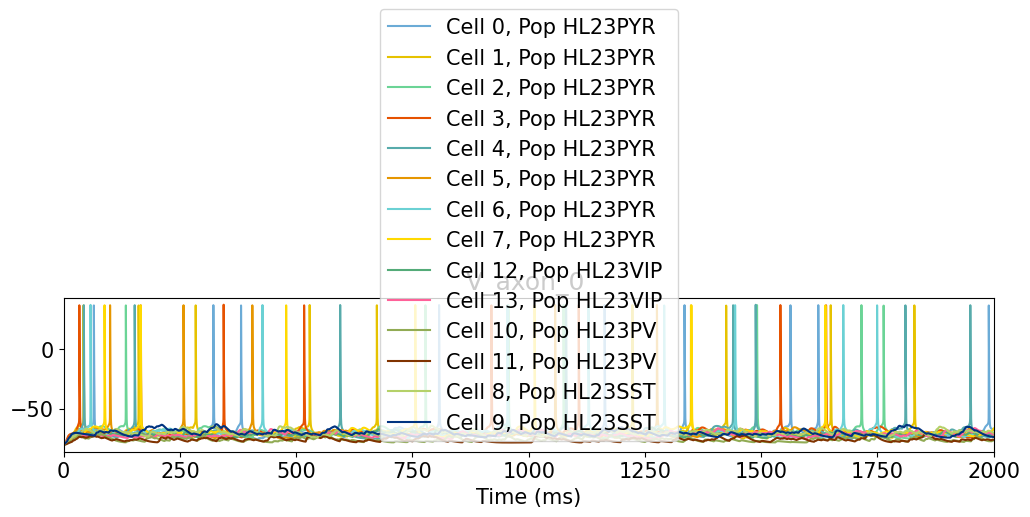

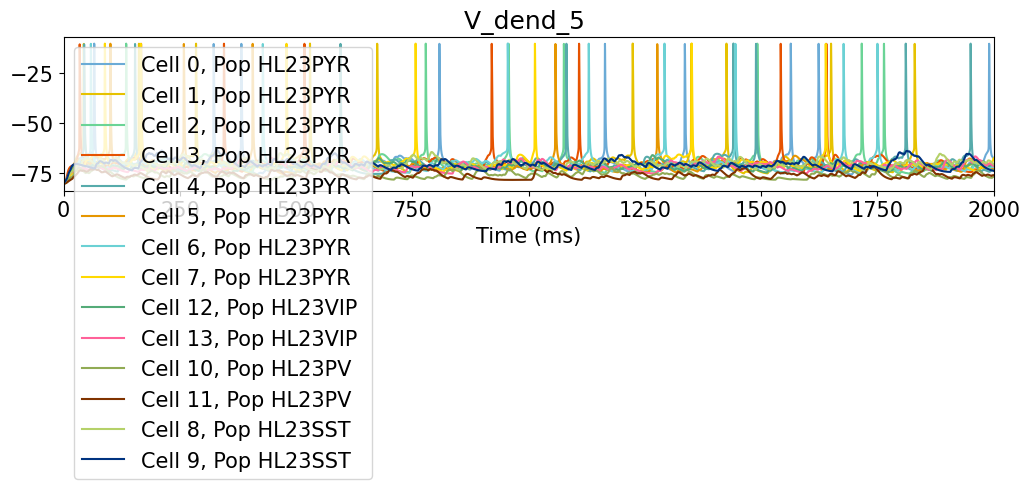

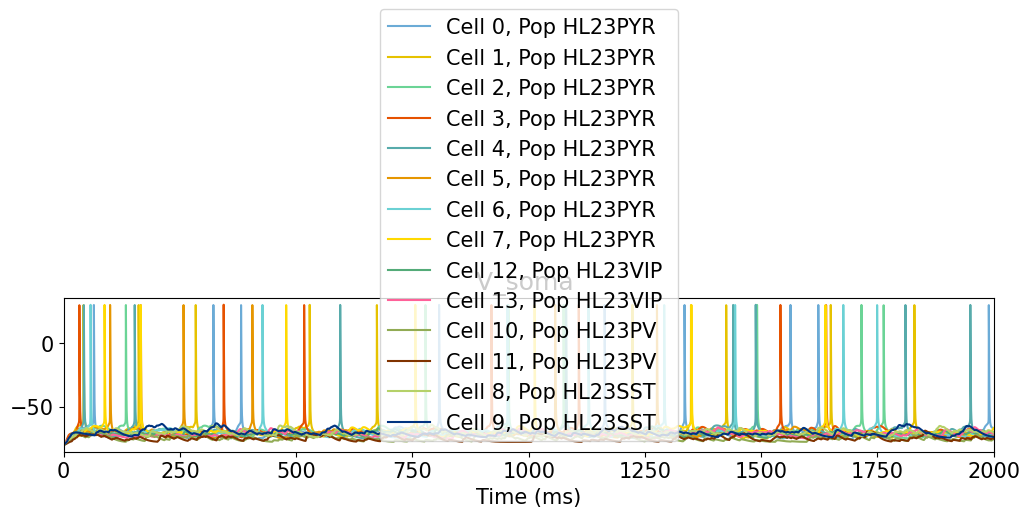

In [ ]:
sim.analysis.plotTraces(overlay=True, timeRange=[0,cfg.duration], oneFigPer='trace', figSize=(12,2), fontSize=15, saveFig=False);

In [ ]:
# for section in netParams.cellParams['HL23PYR_rule']['secLists']['all']:
#     print(section,'->',netParams.cellParams['HL23PYR_rule']['secs'][section]['topol']['parentSec'])
#     print(section,netParams.cellParams['HL23PYR_rule']['secs'][section]['geom']['diam'],netParams.cellParams['HL23PYR_rule']['secs'][section]['geom']['L'])

Plotting 2D representation of network cell locations and connections...


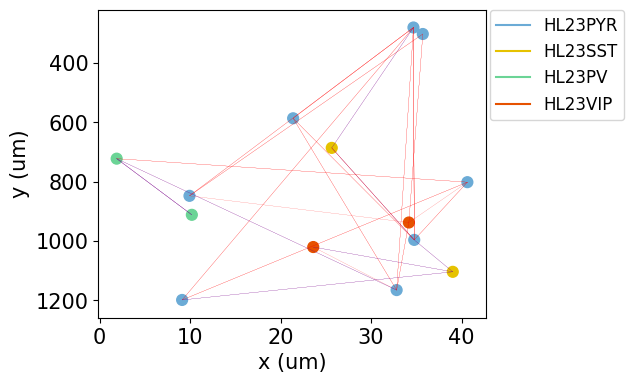

(<Figure size 500x400 with 1 Axes>,
 {'include': ['allCells'],
  'posX': [40.64904419698275,
   9.939082588032658,
   21.393678325645595,
   34.68950156433676,
   34.77493581030453,
   35.721464124727056,
   32.83094967382097,
   9.126554723591825,
   25.661009026493286,
   39.03398017790094,
   1.8941406752924272,
   10.201237092937177,
   34.184680967101016,
   23.617419016258893],
  'posY': [801.4093249916543,
   847.473811451934,
   585.9458392635114,
   279.8026543623296,
   996.0561060123015,
   301.7634254643313,
   1165.283974582496,
   1198.581924091889,
   685.7282480723857,
   1103.7190988767616,
   722.1439468040728,
   911.5043476546407,
   937.4093289283549,
   1020.1086656376467],
  'posXpre': 32.83094967382097,
  'posXpost': 34.184680967101016,
  'posYpre': 1165.283974582496,
  'posYpost': 937.4093289283549})

In [ ]:
sim.analysis.plot2Dnet(figSize=(5, 4), fontSize=12)